# Lab 6 - Neural Networks for Image Classification

# Building a Deep Neural Network

In this lab, you will:
- Implement the building blocks of a deep neural network from scratch
- Apply your implementation to classify cat vs non-cat images

**Notation**:
- Superscript $[l]$ denotes a quantity associated with the $l^{th}$ layer. 
    - Example: $a^{[L]}$ is the $L^{th}$ layer activation. $W^{[L]}$ and $b^{[L]}$ are the $L^{th}$ layer parameters.
- Superscript $(i)$ denotes a quantity associated with the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example.
- Lowerscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the $l^{th}$ layer's activations).

Let's get started!

In [1]:
# Unpack assets
!tar xf data.tar.gz

tar: Error opening archive: Failed to open 'data.tar.gz'


In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from testCases import *
from dnn_utils import sigmoid, sigmoid_backward, relu, relu_backward

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## Outline of Network Architecture

To build your neural network, you will be implementing several "helper functions". These helper functions will be used in the next assignment to build an L-layer neural network. Each small helper function you will implement will have detailed instructions that will walk you through the necessary steps. Here is an outline of this assignment, you will:

- Initialize the parameters for an $L$-layer neural network.
- Implement the forward propagation module (shown in purple in the figure below).
     - Complete the LINEAR part of a layer's forward propagation step (resulting in $Z^{[l]}$).
     - We give you the ACTIVATION function (relu/sigmoid).
     - Combine the previous two steps into a new [LINEAR->ACTIVATION] forward function.
     - Stack the [LINEAR->RELU] forward function L-1 time (for layers 1 through L-1) and add a [LINEAR->SIGMOID] at the end (for the final layer $L$). This gives you a new L_model_forward function.
- Compute the loss.
- Implement the backward propagation module (denoted in red in the figure below).
    - Complete the LINEAR part of a layer's backward propagation step.
    - We give you the gradient of the ACTIVATE function (relu_backward/sigmoid_backward)
    - Combine the previous two steps into a new [LINEAR->ACTIVATION] backward function.
    - Stack [LINEAR->RELU] backward L-1 times and add [LINEAR->SIGMOID] backward in a new L_model_backward function
- Finally update the parameters.

<img src="https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a04_image_classification/images/final outline.png" style="width:800px;height:500px;">
<caption><center> <b> Figure 1 </b></center></caption><br>


<b>Note</b> that for every forward function, there is a corresponding backward function. That is why at every step of your forward module you will be storing some values in a cache. The cached values are useful for computing gradients. In the backpropagation module you will then use the cache to calculate the gradients. This assignment will show you exactly how to carry out each of these steps.

## 1 a) - Initialization (0.5P)

You will write a helper function that will initialize the parameters for your model.

### L-layer Neural Network

The initialization for a deeper L-layer neural network is more complicated because there are many more weight matrices and bias vectors. When completing the `initialize_parameters_deep`, you should make sure that your dimensions match between each layer. Recall that $n^{[l]}$ is the number of units in layer $l$. Thus for example if the size of our input $X$ is $(12288, 209)$ (with $m=209$ examples) then:

<table style="width:100%">
    <tr>
        <td>  </td>
        <td> <b>Shape of W</b> </td>
        <td> <b>Shape of b</b>  </td>
        <td> <b>Activation</b> </td>
        <td> <b>Shape of Activation</b> </td>
    <tr>
    <tr>
        <td> <b>Layer 1</b> </td>
        <td> $(n^{[1]},12288)$ </td>
        <td> $(n^{[1]},1)$ </td>
        <td> $Z^{[1]} = W^{[1]}  X + b^{[1]} $ </td>
        <td> $(n^{[1]},209)$ </td>
    <tr>
    <tr>
        <td> <b>Layer 2</b> </td>
        <td> $(n^{[2]}, n^{[1]})$  </td>
        <td> $(n^{[2]},1)$ </td>
        <td>$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$ </td>
        <td> $(n^{[2]}, 209)$ </td>
    <tr>
       <tr>
        <td> $\vdots$ </td>
        <td> $\vdots$  </td>
        <td> $\vdots$  </td>
        <td> $\vdots$</td>
        <td> $\vdots$  </td>
    <tr>
   <tr>
        <td> <b>Layer L-1</b> </td>
        <td> $(n^{[L-1]}, n^{[L-2]})$ </td>
        <td> $(n^{[L-1]}, 1)$  </td>
        <td>$Z^{[L-1]} =  W^{[L-1]} A^{[L-2]} + b^{[L-1]}$ </td>
        <td> $(n^{[L-1]}, 209)$ </td>
    <tr>
   <tr>
        <td> <b>Layer L</b> </td>
        <td> $(n^{[L]}, n^{[L-1]})$ </td>
        <td> $(n^{[L]}, 1)$ </td>
        <td> $Z^{[L]} =  W^{[L]} A^{[L-1]} + b^{[L]}$</td>
        <td> $(n^{[L]}, 209)$  </td>
    <tr>
</table>

Remember that when we compute $W X + b$ in python, it carries out broadcasting. For example, if:

$$ W = \begin{bmatrix}
    j  & k  & l\\
    m  & n & o \\
    p  & q & r
\end{bmatrix}\;\;\; X = \begin{bmatrix}
    a  & b  & c\\
    d  & e & f \\
    g  & h & i
\end{bmatrix} \;\;\; b =\begin{bmatrix}
    s  \\
    t  \\
    u
\end{bmatrix}\tag{2}$$

Then $WX + b$ will be:

$$ WX + b = \begin{bmatrix}
    (ja + kd + lg) + s  & (jb + ke + lh) + s  & (jc + kf + li)+ s\\
    (ma + nd + og) + t & (mb + ne + oh) + t & (mc + nf + oi) + t\\
    (pa + qd + rg) + u & (pb + qe + rh) + u & (pc + qf + ri)+ u
\end{bmatrix}\tag{3}  $$

<b>Exercise</b>: Implement initialization for an L-layer Neural Network.

<b>Instructions</b>:
- The model's structure is *[LINEAR -> RELU] $ \times$ (L-1) -> LINEAR -> SIGMOID*. I.e., it has $L-1$ layers using a ReLU activation function followed by an output layer with a sigmoid activation function.
- Use random initialization for the weight matrices. Use `np.random.randn(shape) / np.sqrt(shape[1])`. We normalize with the square root of the second shape of W. 
- Use zeros initialization for the biases. Use `np.zeros(shape)`.
- We will store $n^{[l]}$, the number of units in different layers, in a variable `layer_dims`. For two inputs, one hidden layer with 4 hidden units, and an output layer with 1 output unit, for example, this means `W1`'s shape was (4,2), `b1` was (4,1), `W2` was (1,4) and `b2` was (1,1). Now you will generalize this to $L$ layers!
- Here is the implementation for $L=1$ (one layer neural network). It should inspire you to implement the general case (L-layer neural network).
```python
    if L == 1:
        parameters["W" + str(L)] = np.random.randn(layer_dims[1], layer_dims[0]) / np.sqrt(layer_dims[0])
        parameters["b" + str(L)] = np.zeros((layer_dims[1], 1))
```

In [3]:

# GRADED FUNCTION: initialize_parameters_deep
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python list containing the dimensions of each layer in our network
                  e.g., [n_x, n_h1, n_h2, ..., n_y]

    Returns:
    parameters -- python dictionary containing parameters:
                  "W1", "b1", "W2", "b2", ..., "WL", "bL"
                  Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                  bl -- bias vector  of shape (layer_dims[l], 1)
    """
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)  # number of layers including input layer

    for l in range(1, L):
        # Random initialization scaled by sqrt of previous layer size
        parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) / np.sqrt(layer_dims[l - 1])
        # Zeros initialization for biases
        parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))

        # Sanity checks on shapes
        assert parameters["W" + str(l)].shape == (layer_dims[l], layer_dims[l - 1])
        assert parameters["b" + str(l)].shape == (layer_dims[l], 1)

    return parameters


In [4]:
parameters = initialize_parameters_deep([5,4,3])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.72642933 -0.27358579 -0.23620559 -0.47984616  0.38702206]
 [-1.0292794   0.78030354 -0.34042208  0.14267862 -0.11152182]
 [ 0.65387455 -0.92132293 -0.14418936 -0.17175433  0.50703711]
 [-0.49188633 -0.07711224 -0.39259022  0.01887856  0.26064289]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.55030959  0.57236185  0.45079536  0.25124717]
 [ 0.45042797 -0.34186393 -0.06144511 -0.46788472]
 [-0.13394404  0.26517773 -0.34583038 -0.19837676]]
b2 = [[0.]
 [0.]
 [0.]]


<b>Expected output</b>:

<table style="width:80%">
  <tr>
    <td> <b>W1</b> </td>
    <td>[[ 0.72642933 -0.27358579 -0.23620559 -0.47984616  0.38702206]
 [-1.0292794   0.78030354 -0.34042208  0.14267862 -0.11152182]
 [ 0.65387455 -0.92132293 -0.14418936 -0.17175433  0.50703711]
 [-0.49188633 -0.07711224 -0.39259022  0.01887856  0.26064289]]</td>
  </tr>

  <tr>
    <td><b>b1</b> </td>
    <td>[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]</td>
  </tr>

  <tr>
    <td><b>W2</b> </td>
    <td>[[-0.55030959  0.57236185  0.45079536  0.25124717]
 [ 0.45042797 -0.34186393 -0.06144511 -0.46788472]
 [-0.13394404  0.26517773 -0.34583038 -0.19837676]]</td>
  </tr>

  <tr>
    <td><b>b2<b> </td>
    <td>[[ 0.]
 [ 0.]
 [ 0.]]</td>
  </tr>

</table>

## Forward propagation module

### Linear Forward
- LINEAR
- LINEAR -> ACTIVATION where ACTIVATION will be either ReLU or Sigmoid.
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID (whole model)

The linear forward module (vectorized over all the examples) computes the following equations:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{4}$$

where $A^{[0]} = X$.

In [5]:
# GRADED FUNCTION: linear_forward

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [6]:
A, W, b = linear_forward_test_case()

Z, linear_cache = linear_forward(A, W, b)
print("Z = " + str(Z))

Z = [[ 3.26295337 -1.23429987]]


<b>Expected output</b>:

<table style="width:35%">

  <tr>
    <td> <b>Z</b> </td>
    <td> [[ 3.26295337 -1.23429987]] </td>
  </tr>

</table>

### Linear-Activation Forward

In this notebook, you will use two activation functions:

- <b>Sigmoid</b>: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$. We have provided you with the `sigmoid` function. This function returns <b>two</b> items: the activation value "`a`" and a "`cache`" that contains "`Z`" (it's what we will feed in to the corresponding backward function). To use it you could just call:
``` python
A, activation_cache = sigmoid(Z)
```

- <b>ReLU</b>: The mathematical formula for ReLu is $A = RELU(Z) = max(0, Z)$. We have provided you with the `relu` function. This function returns <b>two</b> items: the activation value "`A`" and a "`cache`" that contains "`Z`" (it's what we will feed in to the corresponding backward function). To use it you could just call:
``` python
A, activation_cache = relu(Z)
```

For more convenience, we are going to group two functions (Linear and Activation) into one function (LINEAR->ACTIVATION).

In [7]:
# GRADED FUNCTION: linear_activation_forward

def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [8]:
A_prev, W, b = linear_activation_forward_test_case()

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "sigmoid")
print("With sigmoid: A = " + str(A))

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "relu")
print("With ReLU: A = " + str(A))

With sigmoid: A = [[0.96890023 0.11013289]]
With ReLU: A = [[3.43896131 0.        ]]


<b>Note</b>: In deep learning, the "[LINEAR->ACTIVATION]" computation is counted as a single layer in the neural network, not two layers.

## 1 b) L-Layer Model forward pass (0.5P)

For even more convenience when implementing the $L$-layer Neural Net, you will need a function that replicates the previous one (`linear_activation_forward` with RELU) $L-1$ times, then follows that with one `linear_activation_forward` with SIGMOID.

<img src="https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a04_image_classification/images/model_architecture_kiank.png" style="width:600px;height:300px;">
<caption><center> <b>Figure 2</b> : *[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID* model</center></caption><br>

<b>Exercise</b>: Implement the forward propagation of the above model.

<b>Instruction</b>: In the code below, the variable `AL` will denote $A^{[L]} = \sigma(Z^{[L]}) = \sigma(W^{[L]} A^{[L-1]} + b^{[L]})$. (This is sometimes also called `Yhat`, i.e., this is $\hat{Y}$.)

<b>Tips<b>:
- Use the functions you had previously written
- Use a for loop to replicate [LINEAR->RELU] (L-1) times
- Don't forget to keep track of the caches in the "caches" list. To add a new value `c` to a `list`, you can use `list.append(c)`.

In [9]:

# GRADED FUNCTION: L_model_forward

def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L of them)
    """

    caches = []
    A = X
    L = len(parameters) // 2  # number of layers in the neural network

    # Implement [LINEAR -> RELU] for layers 1..L-1
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(
            A_prev,
            parameters["W" + str(l)],
            parameters["b" + str(l)],
            activation="relu"
        )
        caches.append(cache)

    # Implement final layer: LINEAR -> SIGMOID for layer L
    AL, cache = linear_activation_forward(
        A,
        parameters["W" + str(L)],
        parameters["b" + str(L)],
        activation="sigmoid"
    )
    caches.append(cache)

    # Given your exercise setup, the output layer has 1 unit, so:
    assert AL.shape == (1, X.shape[1])

    return AL, caches


In [10]:
X, parameters = L_model_forward_test_case_2hidden()
AL, caches = L_model_forward(X, parameters)
print("AL = " + str(AL))
print("Length of caches list = " + str(len(caches)))

AL = [[0.03921668 0.70498921 0.19734387 0.04728177]]
Length of caches list = 3


<table style="width:50%">
  <tr>
    <td> <b>AL</b> </td>
    <td > [[ 0.03921668  0.70498921  0.19734387  0.04728177]]</td>
  </tr>
  <tr>
    <td> <b>Length of caches list </b> </td>
    <td > 3 </td>
  </tr>
</table>

Great! Now you have a full forward propagation that takes the input X and outputs a row vector $A^{[L]}$ containing your predictions. It also records all intermediate values in "caches". Using $A^{[L]}$, you can compute the cost of your predictions.

## 1 c) Cost function (0.5P)

Now you will implement forward and backward propagation. You need to compute the cost, because you want to check if your model is actually learning.

<b>Exercise</b>: Compute the cross-entropy cost $J$, using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$


In [11]:
# GRADED FUNCTION: compute_cost

def compute_cost(AL, Y):
    """
    Implement the cost function defined by binary cross-entropy.

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (0 or 1), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost (a scalar)
    """
    m = Y.shape[1]

    # Numerical stability: clip AL to avoid log(0)
    epsilon = 1e-15
    AL_clipped = np.clip(AL, epsilon, 1 - epsilon)

    # Compute cross-entropy loss
    cost = -(1.0 / m) * np.sum(Y * np.log(AL_clipped) + (1 - Y) * np.log(1 - AL_clipped))

    cost = np.squeeze(cost)  # ensure scalar shape
    assert cost.shape == (), f"Cost should be a scalar, got shape {cost.shape}"
    
    return cost


In [12]:
Y, AL = compute_cost_test_case()

print("cost = " + str(compute_cost(AL, Y)))

cost = 0.2797765635793422


<b>Expected Output</b>:
<table>
    <tr>
    <td><b>cost</b> </td>
    <td> 0.2797765635793422</td>
    </tr>
</table>

## 6 - Backward propagation module

Just like with forward propagation, you will implement helper functions for backpropagation. Remember that back propagation is used to calculate the gradient of the loss function with respect to the parameters.

<b>Reminder</b>:
<img src="https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a04_image_classification/images/backprop_kiank.png" style="width:650px;height:250px;">
<caption><center> <b>Figure 3</b> : Forward and Backward propagation for *LINEAR->RELU->LINEAR->SIGMOID* <br> *The purple blocks represent the forward propagation, and the red blocks represent the backward propagation.*  </center></caption>

<!--
For those of you who are expert in calculus (you don't need to be to do this assignment), the chain rule of calculus can be used to derive the derivative of the loss $\mathcal{L}$ with respect to $z^{[1]}$ in a 2-layer network as follows:

$$\frac{d \mathcal{L}(a^{[2]},y)}{{dz^{[1]}}} = \frac{d\mathcal{L}(a^{[2]},y)}{{da^{[2]}}}\frac{{da^{[2]}}}{{dz^{[2]}}}\frac{{dz^{[2]}}}{{da^{[1]}}}\frac{{da^{[1]}}}{{dz^{[1]}}} \tag{8} $$

In order to calculate the gradient $dW^{[1]} = \frac{\partial L}{\partial W^{[1]}}$, you use the previous chain rule and you do $dW^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial W^{[1]}}$. During the backpropagation, at each step you multiply your current gradient by the gradient corresponding to the specific layer to get the gradient you wanted.

Equivalently, in order to calculate the gradient $db^{[1]} = \frac{\partial L}{\partial b^{[1]}}$, you use the previous chain rule and you do $db^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial b^{[1]}}$.

This is why we talk about <b>backpropagation</b>.
!-->

Now, similar to forward propagation, you are going to build the backward propagation in three steps:
- LINEAR backward
- LINEAR -> ACTIVATION backward where ACTIVATION computes the derivative of either the ReLU or sigmoid activation
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID backward (whole model)

## 1 d) Linear backward (0.5P)

For layer $l$, the linear part is: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ (followed by an activation).

Suppose you have already calculated the derivative $dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$. You want to get $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$.

<img src="https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a04_image_classification/images/linearback_kiank.png" style="width:250px;height:300px;">
<caption><center> <b>Figure 4</b> </center></caption>

The three outputs $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$ are computed using the input $dZ^{[l]}$.Here are the formulas you need:
$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$


<b>Exercise</b>: Use the 3 formulas above to implement linear_backward().

In [13]:

# GRADED FUNCTION: linear_backward

def linear_backward(dZ, cache):
    # Here cache is "linear_cache" containing (A_prev, W, b) coming from the forward propagation in the current layer
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l), shape (n_l, m)
    cache -- tuple of values (A_prev, W, b) from forward propagation
             A_prev: (n_{l-1}, m)
             W: (n_l, n_{l-1})
             b: (n_l, 1)

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    # Computing gradients
    dW = (1.0 / m) * np.dot(dZ, A_prev.T)                # shape (n_l, n_{l-1})
    db = (1.0 / m) * np.sum(dZ, axis=1, keepdims=True)   # shape (n_l, 1)
    dA_prev = np.dot(W.T, dZ)                            # shape (n_{l-1}, m)

    # Sanity checks
    assert dA_prev.shape == A_prev.shape
    assert dW.shape == W.shape
    assert db.shape == b.shape
    
    return dA_prev, dW, db


In [14]:
# Set up some test inputs
dZ, linear_cache = linear_backward_test_case()

dA_prev, dW, db = linear_backward(dZ, linear_cache)
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

dA_prev = [[-1.15171336  0.06718465 -0.3204696   2.09812712]
 [ 0.60345879 -3.72508701  5.81700741 -3.84326836]
 [-0.4319552  -1.30987417  1.72354705  0.05070578]
 [-0.38981415  0.60811244 -1.25938424  1.47191593]
 [-2.52214926  2.67882552 -0.67947465  1.48119548]]
dW = [[ 0.07313866 -0.0976715  -0.87585828  0.73763362  0.00785716]
 [ 0.85508818  0.37530413 -0.59912655  0.71278189 -0.58931808]
 [ 0.97913304 -0.24376494 -0.08839671  0.55151192 -0.10290907]]
db = [[-0.14713786]
 [-0.11313155]
 [-0.13209101]]


### Linear-Activation backward

Next, we will create a function that merges the two helper functions: <b>`linear_backward`</b> and the backward step for the activation <b>`linear_activation_backward`</b>.

If $g(.)$ is the activation function,
`sigmoid_backward` and `relu_backward` compute $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}) \tag{11}$$.

In [15]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
    
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [16]:
dAL, linear_activation_cache = linear_activation_backward_test_case()

dA_prev, dW, db = linear_activation_backward(dAL, linear_activation_cache, activation = "sigmoid")
print ("sigmoid:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db) + "\n")

dA_prev, dW, db = linear_activation_backward(dAL, linear_activation_cache, activation = "relu")
print ("relu:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

sigmoid:
dA_prev = [[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]]
dW = [[ 0.10266786  0.09778551 -0.01968084]]
db = [[-0.05729622]]

relu:
dA_prev = [[ 0.44090989 -0.        ]
 [ 0.37883606 -0.        ]
 [-0.2298228   0.        ]]
dW = [[ 0.44513824  0.37371418 -0.10478989]]
db = [[-0.20837892]]


<b>Expected output with sigmoid:</b>

<table style="width:100%">
  <tr>
    <td>
        <b> dA_prev </b>
     </td>
     <td>
         [[ 0.11017994  0.01105339]
         [ 0.09466817  0.00949723]
         [-0.05743092 -0.00576154]]
      </td>
  </tr>
    <tr>
        <td>
            <b> dW </b>
        </td>
        <td>
            [[ 0.10266786  0.09778551 -0.01968084]]
        </td>
  </tr>
    <tr>
        <td>
        <b> db </b>
       </td>
       <td >
           [[-0.05729622]]
        </td>
  </tr>
</table>

<b>Expected output with relu:</b>

<table style="width:100%">
  <tr>
    <td ><b> dA_prev </b> </td>
    <td > [[ 0.44090989  0.        ]
          [ 0.37883606  0.        ]
          [-0.2298228   0.        ]] </td>

  </tr>
    <tr>
    <td ><b> dW </b></td>
           <td > [[ 0.44513824  0.37371418 -0.10478989]] </td>
  </tr>
    <tr>
    <td ><b> db </b></td>
           <td > [[-0.20837892]] </td>
  </tr>
</table>




## 1 e) L-Model Backward (1P)

Now you will implement the backward function for the whole network. Recall that when you implemented the `L_model_forward` function, at each iteration, you stored a cache which contains (X,W,b, and z). In the back propagation module, you will use those variables to compute the gradients. Therefore, in the `L_model_backward` function, you will iterate through all the hidden layers backward, starting from layer $L$. On each step, you will use the cached values for layer $l$ to backpropagate through layer $l$. Figure 5 below shows the backward pass.


<img src="https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a04_image_classification/images/mn_backward.png" style="width:450px;height:300px;">
<caption><center>  <b>Figure 5</b> : Backward pass  </center></caption>

<b> Initializing backpropagation</b>:
To backpropagate through this network, we know that the output is,
$A^{[L]} = \sigma(Z^{[L]})$. Your code thus needs to compute `dAL` $= \frac{\partial \mathcal{L}}{\partial A^{[L]}}$.
To do so, use this formula (derived using calculus which you don't need in-depth knowledge of):
```python
dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
```

You can then use this post-activation gradient `dAL` to keep going backward. As seen in Figure 5, you can now feed in `dAL` into the LINEAR->SIGMOID backward function you implemented (which will use the cached values stored by the L_model_forward function). After that, you will have to use a `for` loop to iterate through all the other layers using the LINEAR->RELU backward function. You should store each dA, dW, and db in the grads dictionary. To do so, use this formula :

$$grads["dW" + str(l)] = dW^{[l]}\tag{15} $$

For example, for $l=3$ this would store $dW^{[l]}$ in `grads["dW3"]`.

<b>Exercise</b>: Implement backpropagation for the *[LINEAR->RELU] $\times$ (L-1) -> LINEAR -> SIGMOID* model.

In [17]:

# GRADED FUNCTION: L_model_backward

def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward()), shape (1, m)
    Y -- true "label" vector (0 or 1), shape (1, m)
    caches -- list of caches from linear_activation_forward():
              caches[0..L-2]: caches for ReLU layers
              caches[L-1]:     cache for final Sigmoid layer
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ...
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ...
    """
    grads = {}
    L = len(caches)              # number of layers with parameters
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)      # ensure Y has the same shape as AL

    # 1) Initialize backpropagation: dAL = dJ/dAL for binary cross-entropy
    #    Use numerical stability (clip) to avoid division by zero.
    epsilon = 1e-15
    AL_clipped = np.clip(AL, epsilon, 1.0 - epsilon)
    dAL = -(np.divide(Y, AL_clipped) - np.divide(1 - Y, 1 - AL_clipped))

    # 2) Lth layer (SIGMOID -> LINEAR): use caches[L-1]
    current_cache = caches[L - 1]
    dA_prev, dW, db = linear_activation_backward(dAL, current_cache, activation="sigmoid")
    grads["dA" + str(L - 1)] = dA_prev
    grads["dW" + str(L)] = dW
    grads["db" + str(L)] = db

    # 3) Loop from l = L-2 down to 0 for ReLU layers
    for l in reversed(range(L - 1)):
        current_cache = caches[l]
        dA_prev, dW, db = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation="relu")
        grads["dA" + str(l)] = dA_prev
        grads["dW" + str(l + 1)] = dW
        grads["db" + str(l + 1)] = db

    return grads

In [18]:
AL, Y_assess, caches = L_model_backward_test_case()
grads = L_model_backward(AL, Y_assess, caches)
print_grads(grads)

dW1 = [[0.41010002 0.07807203 0.13798444 0.10502167]
 [0.         0.         0.         0.        ]
 [0.05283652 0.01005865 0.01777766 0.0135308 ]]
db1 = [[-0.22007063]
 [ 0.        ]
 [-0.02835349]]
dA1 = [[ 0.23096849 -0.44014127]
 [-0.2535498   0.48317296]
 [ 0.02975755 -0.05670698]]


<b>Expected Output</b>

<table style="width:60%">

  <tr>
      <td><b> dW1 </b></td>
           <td > [[ 0.41010002  0.07807203  0.13798444  0.10502167]
 [ 0.          0.          0.          0.        ]
 [ 0.05283652  0.01005865  0.01777766  0.0135308 ]] </td>
  </tr>
    <tr>
    <td><b> db1 </b></td>
           <td > [[-0.22007063]
 [ 0.        ]
 [-0.02835349]] </td>
  </tr>
  <tr>
  <td><b> dA1 </b></td>
           <td > [[ 0.12913162 -0.44014127]
 [-0.14175655  0.48317296]
 [ 0.01663708 -0.05670698]] </td>

  </tr>
</table>

## 1 f) Update Parameters (1P)

In this section you will update the parameters of the model, using gradient descent: 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{16}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{17}$$

where $\alpha$ is the learning rate. After computing the updated parameters, store them in the parameters dictionary. 

<b>Exercise</b>: Implement `update_parameters()` to update your parameters using gradient descent.

<b>Instructions</b>:
Update parameters using gradient descent on every $W^{[l]}$ and $b^{[l]}$ for $l = 1, 2, ..., L$.


In [19]:

# GRADED FUNCTION: update_parameters

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
                  keys: "W1","b1",...,"WL","bL"
    grads -- python dictionary containing your gradients, output of L_model_backward
             keys: "dW1","db1",...,"dWL","dbL"
    learning_rate -- scalar
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    
    L = len(parameters) // 2  # number of layers in the neural network

    # Update rule for each parameter
    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]

    return parameters


In [20]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads, 0.1)

print ("W1 = "+ str(parameters["W1"]))
print ("b1 = "+ str(parameters["b1"]))
print ("W2 = "+ str(parameters["W2"]))
print ("b2 = "+ str(parameters["b2"]))

W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]


<b>Expected Output</b>:

<table style="width:100%">
    <tr>
    <td><b> W1 </b></td>
           <td > [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]] </td>
  </tr>
    <tr>
    <td><b> b1 </b></td>
           <td > [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]] </b></td>
  </tr>
  <tr>
    <td><b> W2 </b></td>
           <td > [[-0.55569196  0.0354055   1.32964895]]</td>
  </tr>
    <tr>
    <td><b> b2 </b></td>
           <td > [[-0.84610769]] </td>
  </tr>
</table>

# 2 Application: Deep Neural Network for Image Classification

Now comes the fun part of putting everything together! You will use the functions you've implemented to build a deep network and apply it to cat vs non-cat classification. 

**In this section you will:**
- Build and train a deep neural network for image classification
- Evaluate the model's performance on training and test data
- Visualize the results and analyze model behavior

Let's get started!

## Packages

Let's first import all the packages that you will need during this assignment. 
- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.
- dnn_app_utils provides the functions implemented in the "Building your Deep Neural Network: Step by Step" assignment to this notebook.
- np.random.seed(1) is used to keep all the random function calls consistent. It will help us grade your work.

In [21]:
import time
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils import load_data, print_mislabeled_images

np.random.seed(1)

## Dataset

You will use the same "Cat vs non-Cat" dataset as in "Logistic Regression as a Neural Network" (Assignment 2). The model you had built had 70% test accuracy on classifying cats vs non-cats images. Hopefully, your new model will perform a better!

<b>Problem Statement</b>: You are given a dataset ("data.h5") containing:
    - a training set of m_train images labelled as cat (1) or non-cat (0)
    - a test set of m_test images labelled as cat and non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

Let's get more familiar with the dataset. Load the data by running the cell below.

In [22]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

In [23]:
# Example of a picture
index = 25
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

y = 1. It's a cat picture.


In [24]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


You need to reshape and standardize the images before feeding them to the network. The code is given in the cell below.

<img src="https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a04_image_classification/images/imvectorkiank.png" style="width:450px;height:300px;">

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>

In [25]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255
test_x = test_x_flatten/255

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


$12,288$ equals $64 \times 64 \times 3$ which is the size of one reshaped image vector.

## Architecture of your model

Now that you are familiar with the dataset, it is time to build a deep neural network to distinguish cat images from non-cat images.

You will build an L-layer deep neural network and also try out different values for $L$. 

Let's look at the architecture.

### L-layer deep neural network

It is hard to represent an L-layer deep neural network with the representation we used so far for network architecture. However, here is a simplified network representation:

<img src="https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a04_image_classification/images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-layer neural network. <br> The model can be summarized as: <b> [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID </b></center></caption>

<u>Detailed Architecture of figure 3</u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, you take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, you take the sigmoid of the final linear unit. If it is greater than 0.5, you classify it to be a cat.

### General methodology

You will follow the Deep Learning methodology to build the model:

    1. Initialize parameters / Define hyperparameters
    2. Loop for num_epochs:
        Sample mini_batches
        Loop for batch in mini_batches
            a. Forward propagation
            b. Compute cost function
            c. Backward propagation
            d. Update parameters (using parameters, and grads from backprop) 
    4. Use trained parameters to predict labels

Let's now implement those two models!

## L-layer Neural Network with Mini-Batch Gradient Descent

**Exercise**: Implement an $L$-layer neural network with **mini-batch gradient descent** using the structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. 

Instead of using the entire dataset for each gradient descent step (batch gradient descent), you'll divide the dataset into smaller mini-batches and update parameters after processing each mini-batch. This approach:
- Converges faster than batch gradient descent
- Has less noisy updates than stochastic gradient descent (batch size = 1)
- Allows for better parallelization

The helper functions you'll use:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
def random_mini_batches(X, Y, mini_batch_size, seed):
    ...
    return mini_batches
```

## 2 a) Mini-Batch Generation (2P)

Before implementing the full training loop, you'll need a helper function to create mini-batches. This function shuffles the dataset and partitions it into smaller batches for more efficient training.

In [27]:
# GRADED FUNCTION: random_mini_batches
def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    """
    Creates a list of random mini-batches from (X, Y).
    
    Arguments:
    X -- input data of shape (n_x, m)
    Y -- labels of shape (1, m)
    mini_batch_size -- size of the mini-batches
    seed -- random seed for reproducibility
    
    Returns:
    mini_batches -- list of tuples (mini_batch_X, mini_batch_Y)
                    Each tuple contains a mini-batch of data and corresponding labels
    """
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []  # This will be a list of tuples: [(X_batch1, Y_batch1), (X_batch2, Y_batch2), ...]

    # Basic sanity checks
    assert X.shape[1] == Y.shape[1], "X and Y must have the same number of examples (columns)"
    assert mini_batch_size >= 1, "mini_batch_size must be at least 1"

    # Step 1: Shuffle (X, Y)
    # Create a random permutation of indices from 0 to m-1
    permutation = np.random.permutation(m)
    # Shuffle X and Y using the permutation (shuffle columns)
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]

    # Step 2: Partition (shuffled_X, shuffled_Y) into mini-batches
    # Calculate the number of complete mini-batches
    num_complete_minibatches = m // mini_batch_size

    # Loop through each complete mini-batch and extract the data
    # For mini-batch k, extract columns from k*mini_batch_size to (k+1)*mini_batch_size
    for k in range(num_complete_minibatches):
        start = k * mini_batch_size
        end = (k + 1) * mini_batch_size
        mini_batch_X = shuffled_X[:, start:end]
        mini_batch_Y = shuffled_Y[:, start:end]
        mini_batches.append((mini_batch_X, mini_batch_Y))

    # Step 3: Handle the end case (last mini-batch < mini_batch_size)
    # Check if there are remaining examples after the complete mini-batches
    remainder = m % mini_batch_size
    if remainder != 0:
        start = num_complete_minibatches * mini_batch_size
        mini_batch_X = shuffled_X[:, start:m]
        mini_batch_Y = shuffled_Y[:, start:m]
        mini_batches.append((mini_batch_X, mini_batch_Y))

    return mini_batches


## 2 b) Mini-Batch Optimization and Model Training (4P)
Combine the previous functions to implement a full training loop with mini-batch gradient descent for the defined L-layer neural network.

In [28]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_epochs=3000, mini_batch_size=64, print_cost=False):
    """
    Implements a L-layer neural network with mini-batch gradient descent: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1)
    learning_rate -- learning rate of the gradient descent update rule
    num_epochs -- number of iterations of the optimization loop
    mini_batch_size -- size of each mini-batch
    print_cost -- if True, prints the cost every 100 epochs and plots the learning curve
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    costs = []  # keep track of cost

    # Parameters initialization
    parameters = initialize_parameters_deep(layers_dims)

    # Loop (gradient descent)
    for i in range(num_epochs):

        # Create mini-batches (reshuffle each epoch with changing seed)
        minibatches = random_mini_batches(X, Y, mini_batch_size=mini_batch_size, seed=i)

        cost_total = 0.0

        # Loop through each mini-batch
        for (minibatch_X, minibatch_Y) in minibatches:
            # Forward propagation on the mini-batch
            AL, caches = L_model_forward(minibatch_X, parameters)

            # Compute cost on the mini-batch
            cost = compute_cost(AL, minibatch_Y)

            # Backward propagation on the mini-batch
            grads = L_model_backward(AL, minibatch_Y, caches)

            # Update parameters using gradients
            parameters = update_parameters(parameters, grads, learning_rate)

            # Accumulate cost
            cost_total += cost

        # Average cost across all mini-batches (simple average)
        cost_avg = cost_total / len(minibatches)

        # Print the cost every 100 epochs
        if print_cost and i % 100 == 0:
            print(f"Cost after epoch {i}: {cost_avg:.6f}")
            costs.append(cost_avg)

    # Plot the cost curve
    if print_cost and len(costs) > 0:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('epochs (per hundreds)')
        plt.title("Learning rate = " + str(learning_rate))
        plt.show()

    return parameters


You will now train the model as a 2-layer neural network. 

Run the cell below to train your model. It may take up to 5 minutes to run 2500 iterations. Check if the "Cost after iteration 0" matches the expected output below, if not click on the square (⬛) on the upper bar of the notebook to stop the cell and try to find your error.

In [29]:
### CONSTANTS ###
n_x = 12288  # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims_2L = (n_x, n_h, n_y)  # 2-layer model

Cost after epoch 0: 0.665154
Cost after epoch 100: 0.437478
Cost after epoch 200: 0.396118
Cost after epoch 300: 0.130267
Cost after epoch 400: 0.081955
Cost after epoch 500: 0.041127
Cost after epoch 600: 0.029937
Cost after epoch 700: 0.026969
Cost after epoch 800: 0.015909
Cost after epoch 900: 0.013304
Cost after epoch 1000: 0.009728
Cost after epoch 1100: 0.008193
Cost after epoch 1200: 0.006885
Cost after epoch 1300: 0.005867
Cost after epoch 1400: 0.006165
Cost after epoch 1500: 0.005023
Cost after epoch 1600: 0.004343
Cost after epoch 1700: 0.003502
Cost after epoch 1800: 0.003967
Cost after epoch 1900: 0.003380
Cost after epoch 2000: 0.002849
Cost after epoch 2100: 0.002612
Cost after epoch 2200: 0.002405
Cost after epoch 2300: 0.002398
Cost after epoch 2400: 0.002247


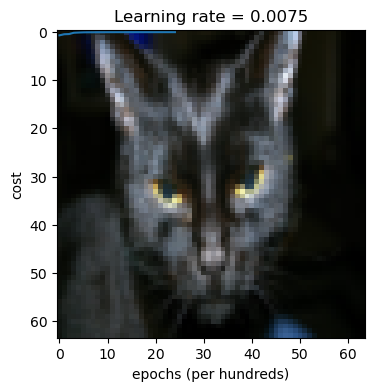

In [30]:
parameters = L_layer_model(train_x, train_y, layers_dims_2L, num_epochs = 2500, print_cost = True)

Good thing you built a vectorized implementation! Otherwise it might have taken 10 times longer to train this.

Now, you can use the trained parameters to classify images from the dataset. To see your predictions on the training and test sets, run the cells below.

In [31]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [32]:
predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


array([[0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
        1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
        1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0.]])

In [33]:
predict(test_x, test_y, parameters)

Accuracy: 0.74


array([[1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1.,
        1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
        1., 0.]])

In [34]:
### CONSTANTS ###
layers_dims_4L = [12288, 20, 7, 5, 1] #  4-layer model

Cost after epoch 0: 0.719190
Cost after epoch 100: 0.625780
Cost after epoch 200: 0.450054
Cost after epoch 300: 0.304465
Cost after epoch 400: 0.179675
Cost after epoch 500: 0.107918
Cost after epoch 600: 0.089095
Cost after epoch 700: 0.062363
Cost after epoch 800: 0.052481
Cost after epoch 900: 0.043312
Cost after epoch 1000: 0.073722
Cost after epoch 1100: 0.035294
Cost after epoch 1200: 0.034233
Cost after epoch 1300: 0.031059
Cost after epoch 1400: 0.029655
Cost after epoch 1500: 0.028932
Cost after epoch 1600: 0.071418
Cost after epoch 1700: 0.026977
Cost after epoch 1800: 0.071742
Cost after epoch 1900: 0.026071
Cost after epoch 2000: 0.026306
Cost after epoch 2100: 0.025805
Cost after epoch 2200: 0.025516
Cost after epoch 2300: 0.025001
Cost after epoch 2400: 0.025287


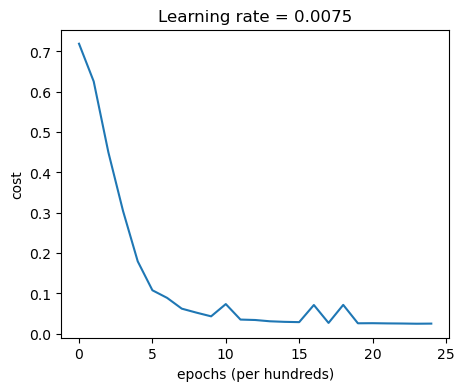

In [35]:
parameters = L_layer_model(train_x, train_y, layers_dims_4L, num_epochs = 2500, print_cost = True)

In [36]:
predict(train_x, train_y, parameters);

Accuracy: 0.9952153110047844


In [41]:
pred_test = predict(test_x, test_y, parameters);

Accuracy: 0.8600000000000001


Congrats! It seems that your 4-layer neural network has better performance than your 2-layer neural network on the same test set. 

##  Results Analysis

First, let's take a look at some images the L-layer model labeled incorrectly. This will show a few mislabeled images. 

In [42]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

<b>A few types of images the model tends to do poorly on include:</b>
- Cat body in an unusual position
- Cat appears against a background of a similar color
- Unusual cat color and species
- Camera Angle
- Brightness of the picture
- Scale variation (cat is very large or small in image)

## Test with your own image (optional/ungraded exercise) ##

In [ ]:
from PIL import Image

fileImage = Image.open("test.png").convert("RGB").resize([num_px,num_px],Image.LANCZOS)
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)

image = np.array(fileImage)
my_image = image.reshape(num_px*num_px*3,1)
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.figure(figsize=(5,5))
plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")